## Recuperation des paramètres libres

Cette procedure represente une étape fondamentale pour pouvoir intérpreter les valeurs estimés des parametres libres. Elle consiste dans une évaluation de la qualité de la procedure d'estimation.

La procedure est très simple et consiste en deux étapes:

-  D'abord on simule les choix du modèle avec des parametres que on choisit.

-  Ensuite on donne les choix du modèle à notre processus d'estimation et on voit à quel point les parametres estimé correspond au paramètres que nous avons utilisé pour faire la simulation

Comme le processus est stochastique, c'est normale d'avoir une correspondance non parfaitment exacte entre les parametètres utilisés pour engendrer les simulations et les parametrès estimées, donc nous allons répétér le processus plusieurs fois pour évaluer la qualité du processus d'estimation sur la base de plusiers points.


## Code

Comme dans le code pour l'estimation, aussi dans cette partie nous ferons appelle à deux fonctions:

- dans le dossier "my_models" : il y a une fonction qui s'appelle Qmodel, qui produit des choix simulés du modèle avec certains paramètres libres (alpha et inv_temp) et certaines caractéristiques de la tâche expérimentale comme le nombre d'essais (ntrials) et le nombre de blocs d'apprentissage (nruns)..

- dans le dossier "my_functions" : il y a une fonction qui s'appelle estimateQ_gridsearch qui exécute le grid search pour trouver les meilleures valeurs des paramètres libres du Qmodel, étant donné les choix (ch) et l'historique des récompenses obtenues (r) ainsi que les caractéristiques de la tâche (nruns) d'un certain participant.


### Definire ou trouver les fonctions


In [7]:
here = pwd
addpath(genpath(fullfile(here,'my_models')));
addpath(genpath(fullfile(here,'my_functions')));

here = '/Users/pool/Documents/Teaching/PA/AdvanceSignal/code/4-recuperer_parametres'

### Définir les variables "input"

Ici au début du code nous allons définir les variables que nous voulons facilement modifer

In [8]:
nsub    = 300; % nombre de participants
ntrials = 100; % nombre d'essais
nruns   =  10; % nombre de bloques d'apprentissage

### Initialiser les variables "output"

Ici nous allons initialiser des matrices vides (NaN) dans lesquelles nous allons sauvgarder les résultats des notre processsus.



In [10]:
simulated_param = nan(nsub,2);
recovered_param = nan(nsub,2);

### Définir les variables du processus d'estimation

Ici nous allons définir variables pour le processus d'estimation des parametres qui utilise la fonction d'optimisation *fmincon*



In [11]:
% nombre de point initial (e.g., combinaison de valeur de parametres libres) dans lequel la fonction 
% d'optimisation va commencer
nstarts = 5;

% definition des valeurs limites de nos deux parametres
xmin    = [0 0]; % Min : première colonne temperature et deuxième colonne alpha
xmax    = [5 1]; % Max : première colonne temperature et deuxième colonne alpha

% ici on définit les options spécifiques à fmincon
options = optimset('Algorithm', 'interior-point', 'Display', 'iter-detailed', 'MaxIter', 10000, 'Display','off'); % These increase the number of iterations to ensure the convergence
warning off all


### Définir les distributions des paramètres libres pour les simulations

Nous devons choisir plusiers valuers de $\alpha$ e de $\beta$, pour ce faire nous allons pas pêcher complètament au hasard, mais nous allons suivre des distributions dans lesquelles certain valeurs des parametres seront plus souvant choisit que d'autres. 

- **Pour la temperature inverse ($\beta$)**: Le plus ce valeur est grand, le plus les gens explorent les effects de choisir l'option qui a le moins de valuer, selon la base des études précedant, nous savons que les gens explore un peu, mais mais pas tout le temps, donc nous utilison une distribution gamma qui determine que les valuers le plus choisit sont les moins elevées. La distribution gamma varie selon deux de paramètre: la forme $ k $ et l' échelle $\theta$ . Dans le code ci-dessous vous pouvez modifier les paramètre de la fonction gamma pour voir les effects sur la distribution de la densité de probabilité.


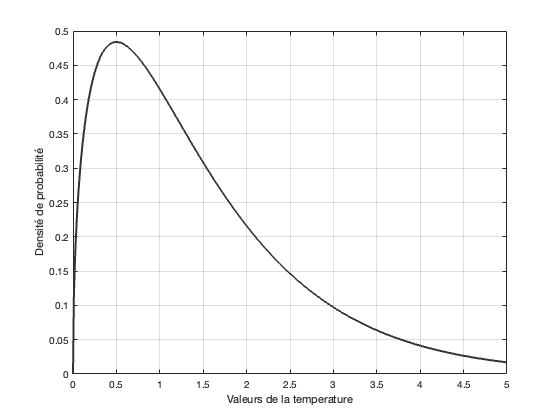

In [12]:
% graphique de la distrubtion pour la temperature

x = 0:0.01:5;  

forme  =1.5;
echelle= 1;

distr_tp = gampdf(x, forme, echelle);

figure

plot(x, distr_tp, 'Color', .2 * [1, 1, 1], 'LineWidth',2)
xlabel('Valeurs de la temperature');  % x-axis label
ylabel('Densité de probabilité');  % y-axis label

grid on;

Pour notre boucle de simulation nous voulons cette ristribution mais contrainte entre les valeurs maximales et minimales


In [13]:
pd = makedist('Gamma',1.2,1.2);      % definir la ristribution pour la temperature 
temp_pdt = truncate(pd,xmin(1),xmax(1))  % contraindre la distribution par les min et max de la temperature 


temp_pdt = 
  <a href="matlab: helpPopup prob.GammaDistribution">GammaDistribution</a>

  Gamma distribution
    a = 1.2
    b = 1.2
  Truncated to the interval [0, 5]

- **Pour la taux d'apprentissage ($\alpha$)**: Sur la base des études passés nous savons que c'est extremement rare que les gens n'intégrent pas du tout l'erreur de prédiction dans la mis à jours de la valeur ($\alpha = 0$) ou que les gens oublient l'estimation de la valuer précedant et utilisent la valuer de l'erreur de prédiction de manière instantanée ($\alpha = 1$). Nous allons utiliser une distribution bêta. La loi bêta est une distribution de probabilité continue définie sur l'intervalle $[0,1]$. La forme de la loi bêta dépend de deux paramètres $\alpha$ et $\beta$ (attention ils ont les même noms mais il ne correspond pas aux paramètres libres de notre Qmodel) qui contrôlent la forme de la distribution de la densisté de probabilité.  Dans le code ci-dessous vous pouvez modifier ces paramètres pour voir les effects sur la distribution.

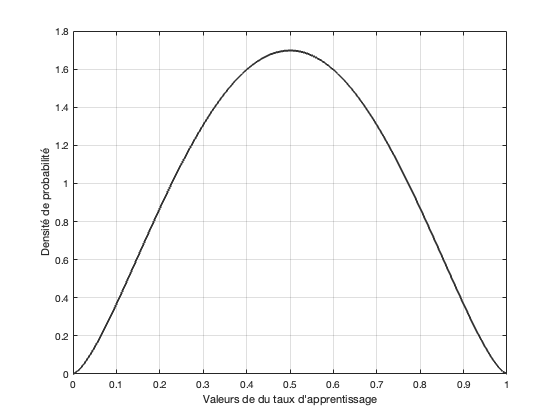

In [14]:
% graphique de la distrubution pour le taux d'apprentissage

x = 0:0.01:1;  
beta_alpha = 2.5;
beta_beta  = 2.5;
distr_tp = betapdf(x, beta_alpha,beta_beta);

figure

plot(x, distr_tp, 'Color', .2 * [1, 1, 1], 'LineWidth',2)
xlabel('Valeurs de du taux d''apprentissage');  % x-axis label
ylabel('Densité de probabilité');               % y-axis label

grid on;

## Boucle pour la simulation et et estimation de plusieurs paramètres libres

Ici pour le nombre de participants que nous avons détérminé au début du script, nous allons:

- tirer les paramètres des distributions que nous avons décrit au préalable.
- sauver les paramètres (temperature et taux d'apprentissage) dans une matrice.
- simuler les choix du modèle avec ces paramètres (e.g., le participant sythetique).
- estimer les paramètres libres sur la base du comportement du participant sythetique. Cela nous le faisons plusieurs fois (nstarts) avec à chaque fois des points initial pour le search différent. Ensuite nous allons selectioner les paramètres qui ont engendré la plus petite vraisemblance négative.
- sauver les paramètres estimées.




In [16]:
for ksub = 1:nsub


    disp (['-------  synthetic participant  ' num2str(ksub) '   -------']);


    % Tirer les paramètres des distributions
    sim_param(ksub).alpha     = random('Beta', 2.5, 2.5);% beta est déjà entre 0 et 1 donc nous n'avons pas besoin de contraindre
    sim_param(ksub).inv_temp  = random(temp_pdt);

    % sauver les valeurs de parametrès que nous avons seléctionné
    simulated_param(ksub,:) = [sim_param(ksub).inv_temp,sim_param(ksub).alpha];

    % simuler le participant sythetitque
    [sim_ch, sim_r] = Qmodel(sim_param(ksub).alpha, sim_param(ksub).inv_temp, ntrials, nruns);

    % estimate free parameters
    nll = nan(nstarts,1); % initialiser un vecteur vide pour sauver la vraisemblance négative
    
    for strt = 1:nstarts % essayer plusieurs recherche avec des différentes de points initial

        x0 = unifrnd(xmin,xmax); % tirer au hasard les points initiaux entre les limites définie
    
        % executer la fonction d'optimisation et sauver la vraisamblence négative et les paramétres estimées
        [rec_param(strt,:),nll(strt),~,~,~] = fmincon(@(x) estimateQ(x,sim_ch,sim_r, nruns),x0,[],[],[],[],xmin,xmax,[],options);

    end

    % trouver le min loglike avec les different paramentres
    minnLL = find(min(nll));

    recovered_param(ksub,:) = rec_param (minnLL,:);

end


-------  synthetic participant  1   -------
-------  synthetic participant  2   -------
-------  synthetic participant  3   -------
-------  synthetic participant  4   -------
-------  synthetic participant  5   -------
-------  synthetic participant  6   -------
-------  synthetic participant  7   -------
-------  synthetic participant  8   -------
-------  synthetic participant  9   -------
-------  synthetic participant  10   -------
-------  synthetic participant  11   -------
-------  synthetic participant  12   -------
-------  synthetic participant  13   -------
-------  synthetic participant  14   -------
-------  synthetic participant  15   -------
-------  synthetic participant  16   -------
-------  synthetic participant  17   -------
-------  synthetic participant  18   -------
-------  synthetic participant  19   -------
-------  synthetic participant  20   -------
-------  synthetic participant  21   -------
-------  synthetic participant  22   -------
-------  synthetic 

## Estimation et visualisation des résultats

Avec le processus ci-dessous nous avons obtenue:
- les parametres utilisés pour engendre les choix du participant simulé ( -> les vrai paramètres)
- les paramètres estimées par notre processus d'estimation des paramètres libres (-> les paramètres récuperées).

Maintenant ce que nous allons faire, c'est evaluer de manière quantitative la correspondance entre les "vrai" paramètres et les paramètres récuperées par notre processus d'estimation. Concrètement, cela consiste dans une régression linaire () dans la quelle on utilise comme 

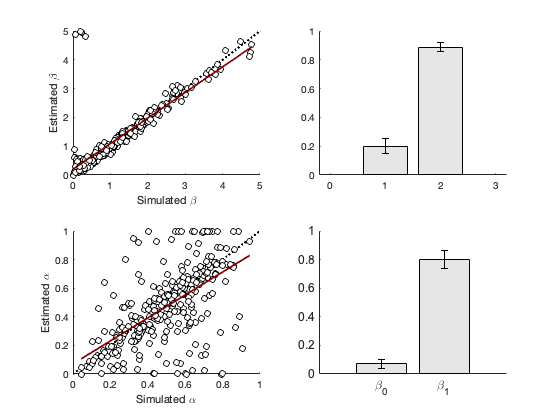

In [18]:

figure


%--------------------------------------------------------------------------
% pannel 1 : Resultats pour


% -------------- subpannel 1 regression with individual datapoints
subplot(2, 2, 1) 

hold on

   
xl = [0 5];

xlabel(strcat('Simulated \beta'));
ylabel(strcat('Estimated \beta'));

X = simulated_param(:, 1);
Y = recovered_param(:, 1);


% plot line r = 1
plot( xl, xl, ':k', 'LineWidth', 2); 

% plot correlation between estimated and simulated
plot( X(:), Y(:), 'o', ...
        'MarkerFaceColor', [1, 1, 1], ...
        'MarkerEdgeColor', [0, 0, 0])

% compute the glm to plot the intrapolation line
[b, ~, stats]  = glmfit(X(:), Y(:), 'normal');
XX             = linspace(min(X(:)), max(X(:)), 1000);
[Yf, Yl, Yh]   = glmval(b, XX, 'identity', stats, 'confidence', 0.95);
XXX            = sortrows([XX', Yf, Yf-Yl, Yf+Yh], 1);
alpha(0.5)
plot(XXX(:,1), XXX(:,2), '-', 'Color', .5 * [1,0,0],'LineWidth', 2);


% -------------- subpannel 2 regression estimates
subplot(2, 2, 2) 

hold on

bar(stats.beta, 'FaceColor', .9 .* [1, 1, 1])
errorbar(stats.beta,stats.se, 'k', 'LineStyle', 'none')


%--------------------------------------------------------------------------
% pannel 1 : alpha estimates

% -------------- subpannel 1 regression with individual datapoints
subplot(2, 2, 3) 

hold on


xlabel(strcat('Simulated \alpha'));
ylabel(strcat('Estimated \alpha'));


X = simulated_param(:, 2);
Y = recovered_param(:, 2);

xl = [0 1];

% plot line r = 1
plot( xl, xl, ':k', 'LineWidth', 2);  

% plot correlation between estimated and simulated
plot( X(:), Y(:), 'o', 'MarkerFaceColor', [1, 1, 1], ...
        'MarkerEdgeColor', [0, 0, 0])

% compute the glm to plot the intrapolation line
[b, ~, stats]      = glmfit(X(:), Y(:), 'normal');
XX             = linspace(min(X(:)), max(X(:)), 1000);
[Yf, Yl, Yh]   = glmval(b, XX, 'identity', stats, 'confidence', 0.95);
XXX            = sortrows([XX', Yf, Yf-Yl, Yf+Yh], 1);
alpha(0.5)
plot(XXX(:,1), XXX(:,2), '-', 'Color', .5 * [1,0,0],'LineWidth', 2);


% -------------- subpannel 2 regression estimates
subplot(2, 2, 4) 

hold on

bar(stats.beta, 'FaceColor', .9 .* [1, 1, 1])
errorbar(stats.beta,stats.se, 'k', 'LineStyle', 'none')
set(gca,'YLim', [0 1], ...
        'XLim', [0 3], ...
        'XTick', [1 2], ...
        'XTickLabel', {'\beta_0','\beta_1'}, ...
        'FontSize', 12, ...
        'FontName', 'Arial')
